In [1]:
"""
Example demonstrating the Robotics Toolbox adapter usage.

This example shows how to use the RTB adapter to:
1. Initialize the environment
2. Load/create robots and objects
3. Perform basic operations like forward kinematics, pose manipulation, etc.
"""

import numpy as np
import spatialmath as sm
import spatialgeometry as sg
from pandaSim.geometry.rtb_adapter import RoboticsToolboxAdapter
from pandaSim.planning.screw_motion_planner import ScrewMotionPlanner
from pandaSim.geometry.utils import convert_pose
from pandaSim.geometry.utils import create_virtual_panda
import trimesh
from pytransform3d import (
    transformations as pt,
    rotations as pr,
    batch_rotations as pb,
    trajectories as ptr,
    plot_utils as ppu
)
import qpsolvers as qp


# auto reload
%load_ext autoreload
%autoreload 2

[I 07/29/25 18:07:44.623 29027] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:
panda_path = '../model/franka_description/robots/frankaEmikaPandaVirtual.urdf'
panda = create_virtual_panda(urdf_path=panda_path)

In [3]:
adapter = RoboticsToolboxAdapter({
    "realtime": True,
    "rate": 100,
    "browser": 'google-chrome' # "notebook" for visualizing in jupyter notebook
})
    
planner = ScrewMotionPlanner()

panda_path = '../model/franka_description/robots/frankaEmikaPandaVirtual.urdf'
panda = create_virtual_panda(urdf_path=panda_path)

env = adapter.env
# Open the gripper fingers (from sample code)
if hasattr(panda, 'grippers') and len(panda.grippers) > 0:
    panda.grippers[0].q = [0.035, 0.035]
    
box = sg.Box(scale=[0.2, 0.07, 0.1], 
             color='blue', 
             pose=sm.SE3(0.7, 0, 0.05))


# end-effector axes
ee_axes = sg.Axes(0.1)

wTb = adapter.forward_kinematics(robot=panda, 
                                       link='panda_finger_virtual', 
                                       output_type='t')
ee_axes.T = wTb
# goal axes
goal_axes = sg.Axes(0.1)

grasp_pose, qs, s_axes = planner.compute_grasp(obj=box, 
                                               adapter=adapter, 
                                               grasp_height='top',
                                               prefer_closer_grasp=True, 
                                               gripper_offset=sm.SE3.Rx(np.pi/2).A, 
                                               output_type='t')

goal_axes.T = grasp_pose
# Add the axes to the environment
env.add(ee_axes)
env.add(goal_axes) 
env.add(panda)
env.add(box)


3

In [4]:
# Direct instantiation
from pandaSim.control import QPController

controller = QPController(adapter=adapter, 
                          robot=panda,
                          end_effector_link='panda_finger_virtual', 
                          gains_translation=2.0, 
                          gains_rotation=2.0, 
                          threshold=0.001, 
                          lambda_q=0.5, 
                          lambda_m=1.0, 
                          lambda_j=1.0,
                          ps=0.5, 
                          pi=0.3, 
                          eta=1.0, 
                          solver='quadprog',
                          T=5)



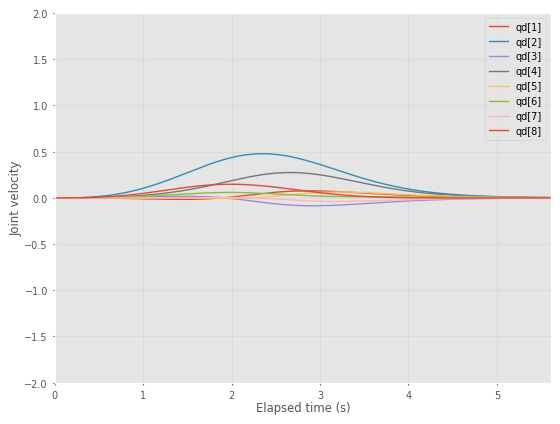

In [5]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
dq_max = 0.01

panda.q = panda.qr
arrived = False

qd_history = []
q_history = []
time_history = []

dt = 0.01
elapsed_time = 0.0

fig, ax = plt.subplots()
lines = [ax.plot([], [], label=f'qd[{i+1}]', linewidth=1)[0] for i in range(panda.n)]
ax.set_xlim(0, 20) 
ax.set_ylim(-2, 2)   
ax.set_xlabel('Elapsed time (s)')
ax.set_ylabel('Joint velocity')
ax.legend()
plt.ion()
plt.show()

step = 0
while not arrived:
    qd, arrived = controller.compute_joint_velocities(grasp_pose, optimization_type="j")
    goal_axes.T = grasp_pose
    qd = controller.smooth_velocity_ramp(qd_cmd=qd, elapsed_time=elapsed_time, method="quintic")
    adapter.control_joint_velocities(panda, qd)
    ee_axes.T = panda.fkine(panda.q, end='panda_finger_virtual')
    adapter.step_simulation(dt)
    qd_history.append(qd[:panda.n].copy())
    q_history.append(panda.q[:panda.n].copy())
    elapsed_time += dt
    time_history.append(elapsed_time)
    if step % 10 == 0:  # update plot every 0.1 seconds for speed
        clear_output(wait=True)
        for i, line in enumerate(lines):
            line.set_data(time_history, [q[i] for q in qd_history])
        ax.set_xlim(0, max(5, elapsed_time))
        display(fig)
    step += 1

q_arrived = panda.q.copy()

plt.ioff()
plt.show()


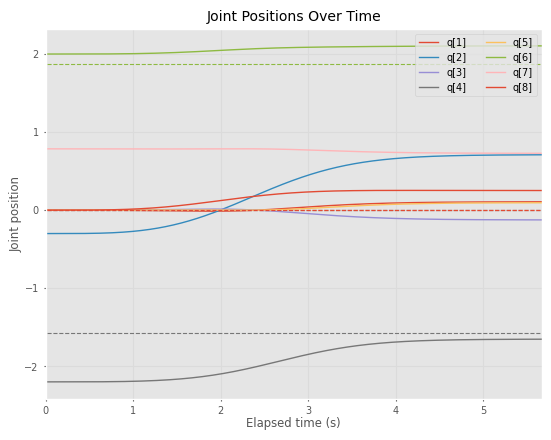

In [6]:
import matplotlib.pyplot as plt

q_history = np.array(q_history)
time_history = np.array(time_history)

# Get joint limits
q_min, q_max = adapter.get_joint_limits(panda)

fig2, ax2 = plt.subplots()
lines = []
for i in range(q_history.shape[1]):
    # Plot joint position
    line, = ax2.plot(time_history, q_history[:, i], label=f'q[{i+1}]', linewidth=1)
    lines.append(line)
    color = line.get_color()
    # Plot middle joint limit as dashed line with same color
    q_mid = (q_min[i] + q_max[i]) / 2
    ax2.hlines(q_mid, time_history[0], time_history[-1], colors=color, linestyles='dashed', linewidth=0.8)

ax2.set_xlim(0, max(time_history))
ax2.set_xlabel('Elapsed time (s)')
ax2.set_ylabel('Joint position')
ax2.set_title('Joint Positions Over Time')
ax2.legend(loc='upper right', ncol=2)
plt.show()




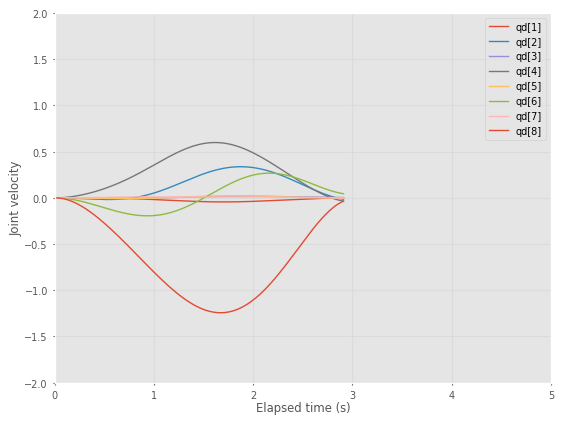

False
False
False
False
False
False
False
True
True


In [18]:
controller = QPController(adapter=adapter, 
                          robot=panda,
                          end_effector_link='panda_finger_virtual', 
                          gains_translation=2.0, 
                          gains_rotation=2.0, 
                          threshold=0.001, 
                          lambda_q=5.0, 
                          lambda_m=1.0, 
                          lambda_j=1.0,
                          ps=0.5, 
                          pi=0.3, 
                          eta=1.0, 
                          solver='quadprog',
                          T=5)



twist_b = planner.generate_twist_trajectory(body_pose=grasp_pose,
                                            q=qs, 
                                            s_axis=s_axes, 
                                            theta=np.pi/2, 
                                            h=0.0, 
                                            theta_dot=0.3,
                                            steps=300, 
                                            time_scaling='quintic', 
                                            body_coordinate=True)

panda.q = q_arrived
arrived = False

qd_history = []
q_history = []
time_history = []

dt = 0.01
elapsed_time = 0.0

fig, ax = plt.subplots()
lines = [ax.plot([], [], label=f'qd[{i+1}]', linewidth=1)[0] for i in range(panda.n)]
ax.set_xlim(0, 20) 
ax.set_ylim(-2, 2)   
ax.set_xlabel('Elapsed time (s)')
ax.set_ylabel('Joint velocity')
ax.legend()
plt.ion()
plt.show()

step = 0
for twist in twist_b:
        print(arrived)
        qd, arrived = controller.compute_joint_velocities(twist=twist, optimization_type="joint_limit")
        goal_axes.T = grasp_pose
        # qd = controller.smooth_velocity_ramp(qd_cmd=qd, elapsed_time=elapsed_time, method="quintic")
        adapter.control_joint_velocities(panda, qd)
        ee_axes.T = panda.fkine(panda.q, end='panda_finger_virtual')
        adapter.step_simulation(dt)
        qd_history.append(qd[:panda.n].copy())
        q_history.append(panda.q[:panda.n].copy())
        elapsed_time += dt
        time_history.append(elapsed_time)
        if step % 10 == 0:  # update plot every 0.1 seconds for speed
            clear_output(wait=True)
            for i, line in enumerate(lines):
                line.set_data(time_history, [q[i] for q in qd_history])
            ax.set_xlim(0, max(5, elapsed_time))
            display(fig)
        step += 1



plt.ioff()
plt.show()

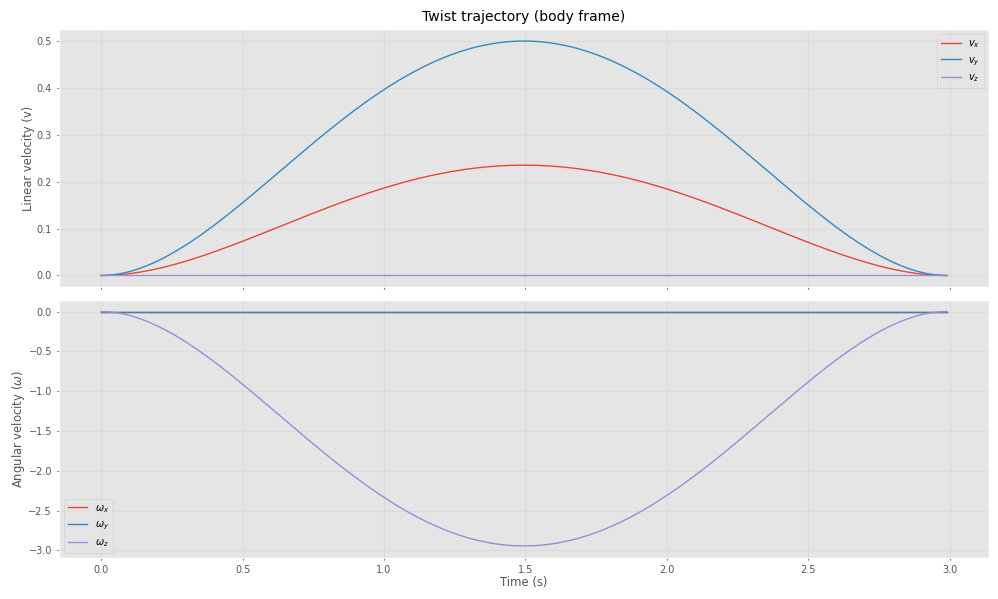

In [8]:
# Plot twist_b: (v, omega) order, shape (N, 6)
time_twist = np.arange(len(twist_b)) * dt
labels = [r'$v_x$', r'$v_y$', r'$v_z$', r'$\omega_x$', r'$\omega_y$', r'$\omega_z$']
ylabels = ['Linear velocity (v)', 'Angular velocity ($\omega$)']

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
for i in range(3):
    axes[0].plot(time_twist, twist_b[:, i], label=labels[i], linewidth=1)
    axes[1].plot(time_twist, twist_b[:, i+3], label=labels[i+3], linewidth=1)

for ax, ylabel in zip(axes, ylabels):
    ax.set_ylabel(ylabel)
    ax.legend()
axes[1].set_xlabel('Time (s)')
axes[0].set_title('Twist trajectory (body frame)')
plt.tight_layout()
plt.show()
